In [2]:
from __future__ import annotations
from jetnet.datasets import JetNet

print(f"Particle features: {JetNet.ALL_PARTICLE_FEATURES}")
print(f"Jet features: {JetNet.ALL_JET_FEATURES}")

Particle features: ['etarel', 'phirel', 'ptrel', 'mask']
Jet features: ['type', 'pt', 'eta', 'mass', 'num_particles']


In [3]:
#load the data

data_args = {
    "jet_type": ["g", "t", "w"], #select only gluon, top quark, and W boson jets
    "data_dir": "Week2/JetNet_Classification/datasets/jetnet.py",  
    #only selecting the kinematic features
    "particle_features": ["etarel", "phirel", "ptrel"],
    "num_particles": 30,
    "jet_features": ["type", "pt", "eta", "mass"], 
    "download": True,
}

particle_data, jet_data = JetNet.getData(**data_args)

[██████████████████████████████████████████████████] 100%
[██████████████████████████████████████████████████] 100%
[██████████████████████████████████████████████████] 100%


In [4]:
print(
    f"Particle features of the 10 highest pT particles in the first jet\n{data_args['particle_features']}\n{particle_data[0, :10]}"
)
print(f"\nJet features of first jet\n{data_args['jet_features']}\n{jet_data[0]}")

Particle features of the 10 highest pT particles in the first jet
['etarel', 'phirel', 'ptrel']
[[-0.00872522  0.0235613   0.43259743]
 [-0.00622525  0.02606254  0.09148767]
 [ 0.00339764  0.0216538   0.0566904 ]
 [-0.00122525  0.02606254  0.04370339]
 [-0.00872524  0.01355605  0.04336121]
 [-0.00511965  0.02728388  0.03864702]
 [-0.0052161   0.02134084  0.03471215]
 [-0.00046873  0.02052631  0.03239661]
 [-0.00872525  0.05357655  0.01715468]
 [ 0.18024893 -0.2968408   0.01463768]]

Jet features of first jet
['type', 'pt', 'eta', 'mass']
[ 0.00000000e+00  1.33816968e+03 -9.06274796e-01  1.34846237e+02]


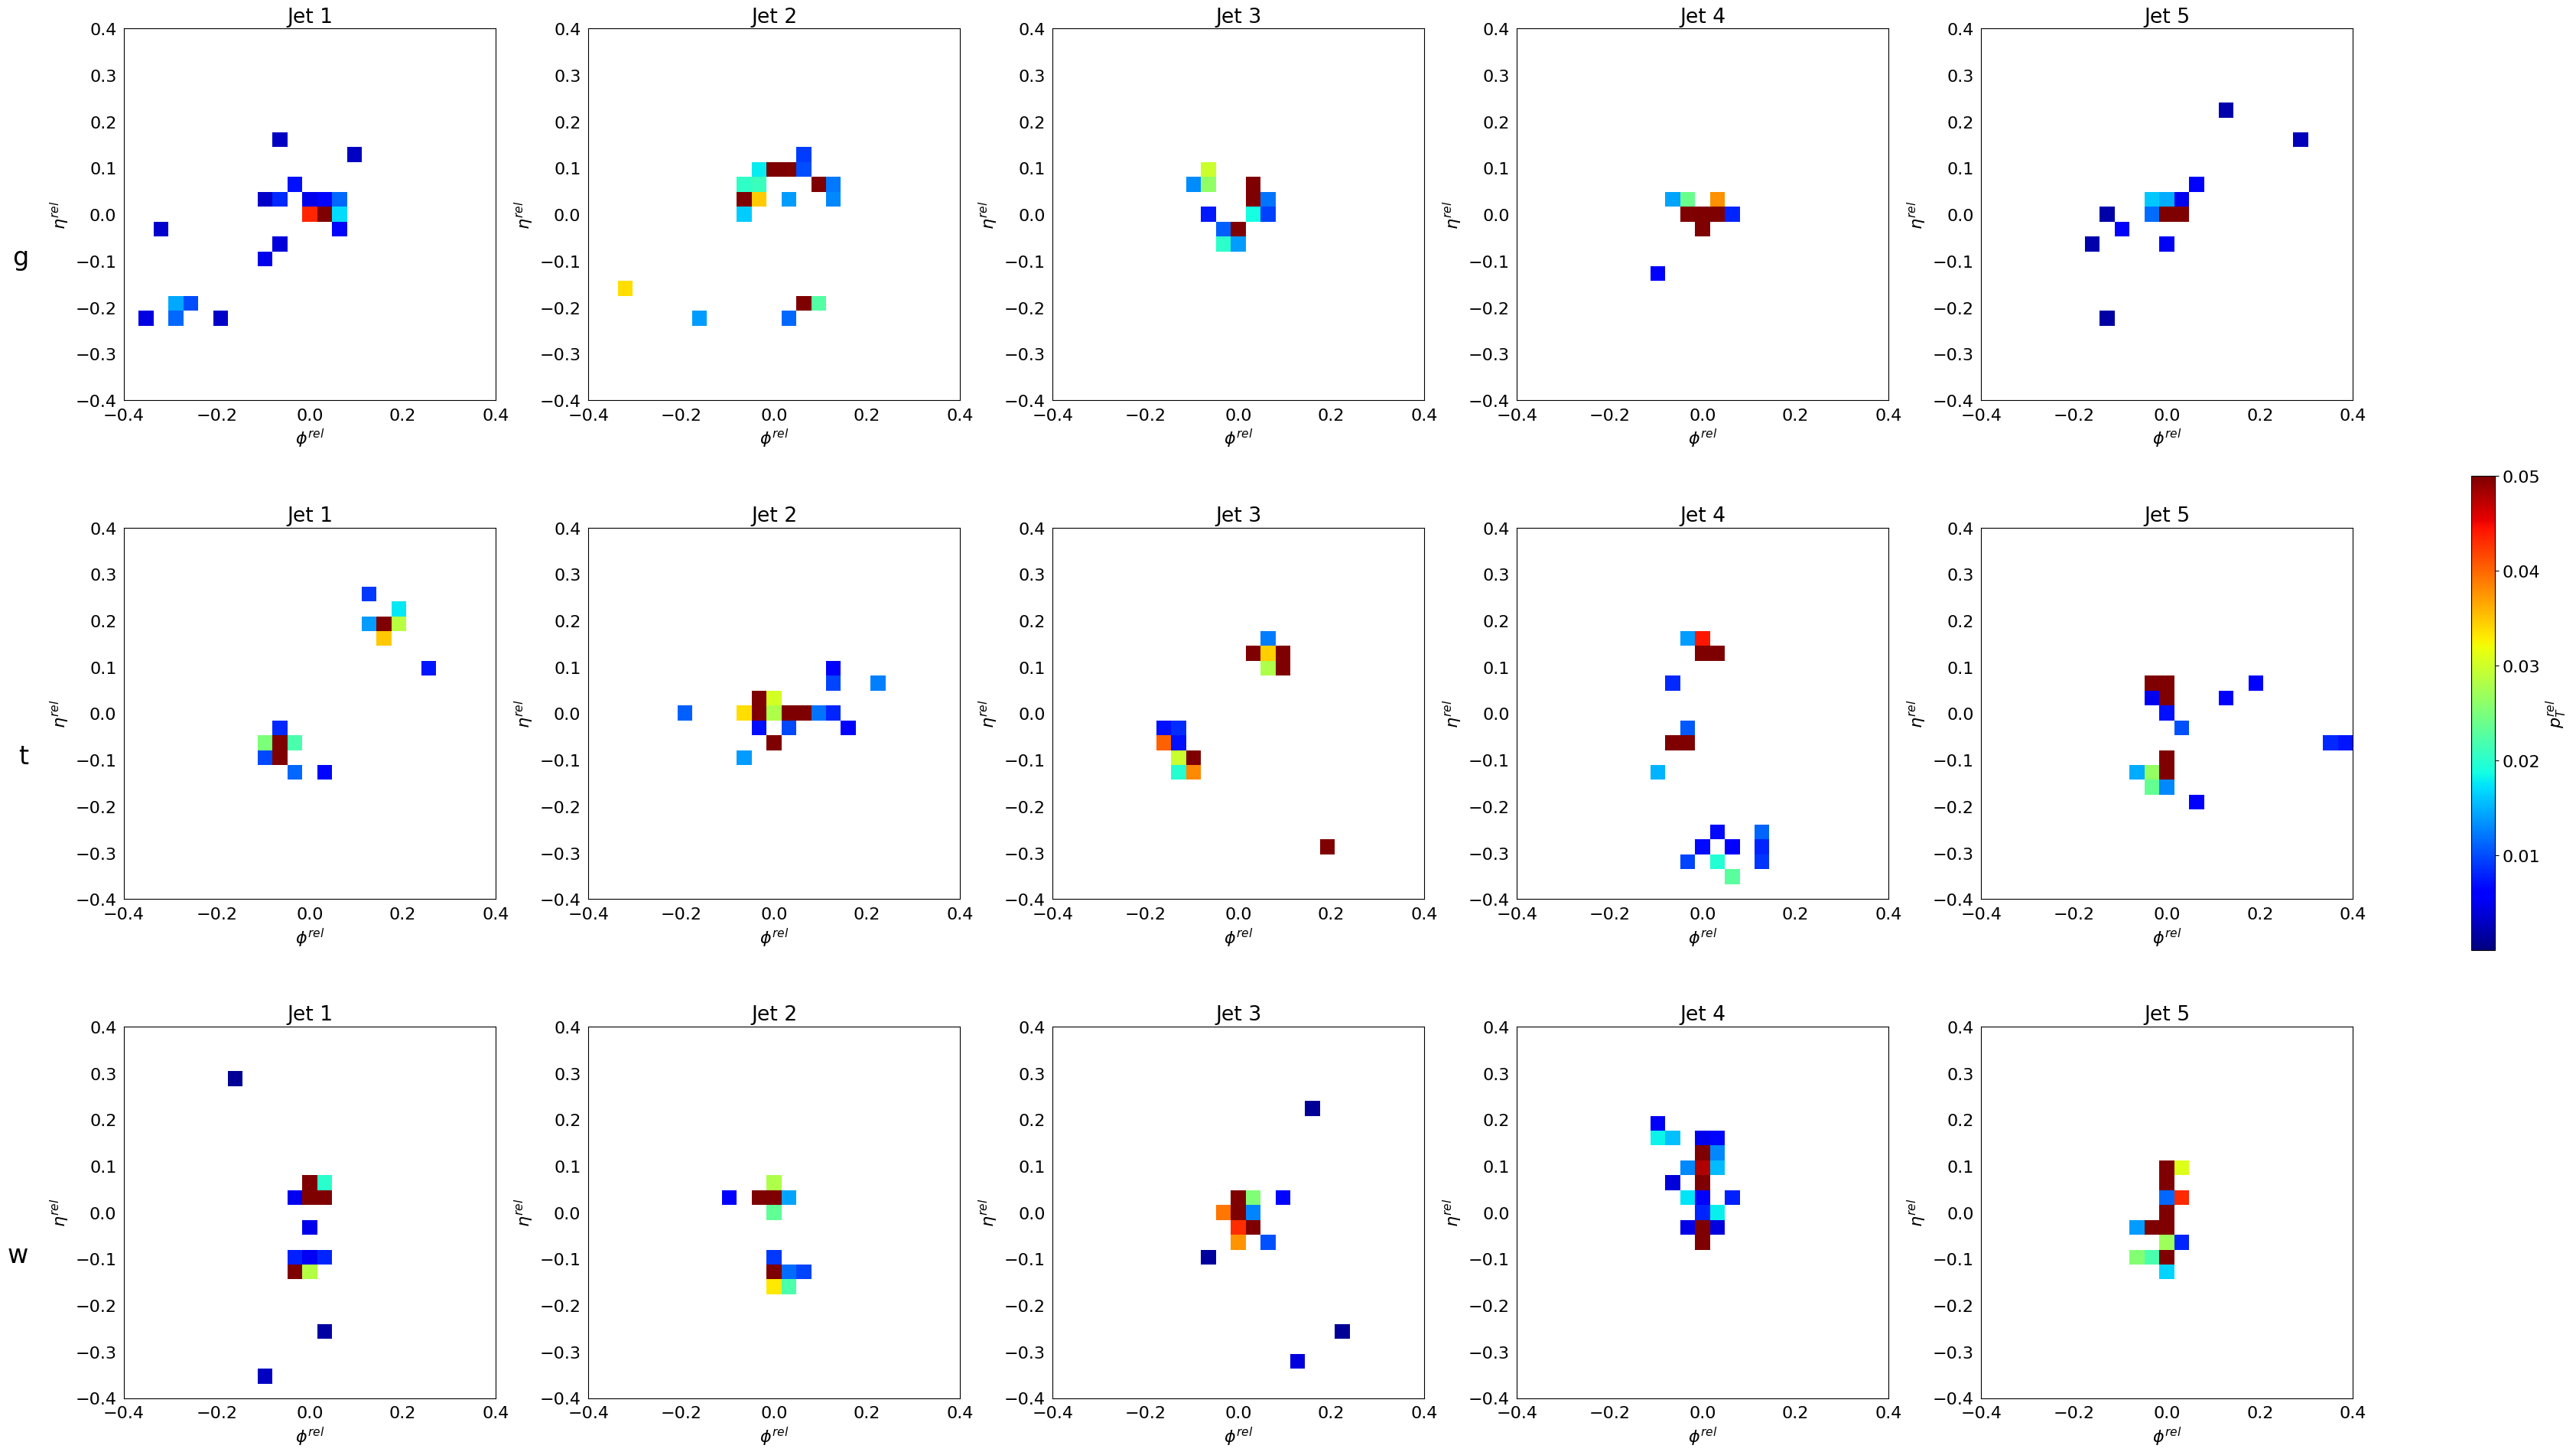

In [9]:
#visualizing these jets as images

import matplotlib.pyplot as plt
from jetnet.utils import to_image

num_images = 5
num_types = len(data_args["jet_type"]) #g, w, and t
im_size = 25 #number of pixels in height adn width
maxR = 0.4 #max radius in (eta, phi) away from the jet axis

cm = plt.cm.jet.copy() #a predefined colormap called "jet", which maps low values to blue and high values to red (through green/yellow).
#copy makes a modifiable copy
cm.set_under(color="white") #set all colors below the minimum val to be white (mask out background)
plt.rcParams.update({"font.size": 16})

fig, axes = plt.subplots(
    nrows = num_types,
    ncols = num_images,
    figsize = (40, 8 * num_types), #width = 40 and height = 8*num_types
    gridspec_kw = {"wspace": 0.25} #width space between the figures
)

#get the index of each jet type using the JetNet.JET_TYPES array
type_indices = {jet_type: JetNet.JET_TYPES.index(jet_type) for jet_type in data_args["jet_type"]}

for j in range(num_types):
    jet_type = data_args["jet_type"][j]
    type_selector = jet_data[:,0] == type_indices[jet_type] #select jets based on jet_type features

    axes[j][0].annotate(
        jet_type, 
        xy = (0, -1),
        xytext=(-axes[j][0].yaxis.labelpad - 15, 0),
        xycoords = axes[j][0].yaxis.label,
        textcoords = "offset points",
        ha = "right",
        va = "center",
        fontsize = 24
    )

    for i in range(num_images):
        im = axes[j][i].imshow(
            to_image(particle_data[type_selector][i], im_size, maxR=maxR),
            cmap=cm,
            interpolation="nearest",
            vmin=1e-8,
            extent=[-maxR, maxR, -maxR, maxR],
            vmax=0.05,
        )
        axes[j][i].tick_params(which="both", bottom=False, top=False, left=False, right=False)
        axes[j][i].set_xlabel("$\phi^{rel}$")
        axes[j][i].set_ylabel("$\eta^{rel}$")
        axes[j][i].set_title(f"Jet {i + 1}")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.01)
cbar.set_label("$p_T^{rel}$")

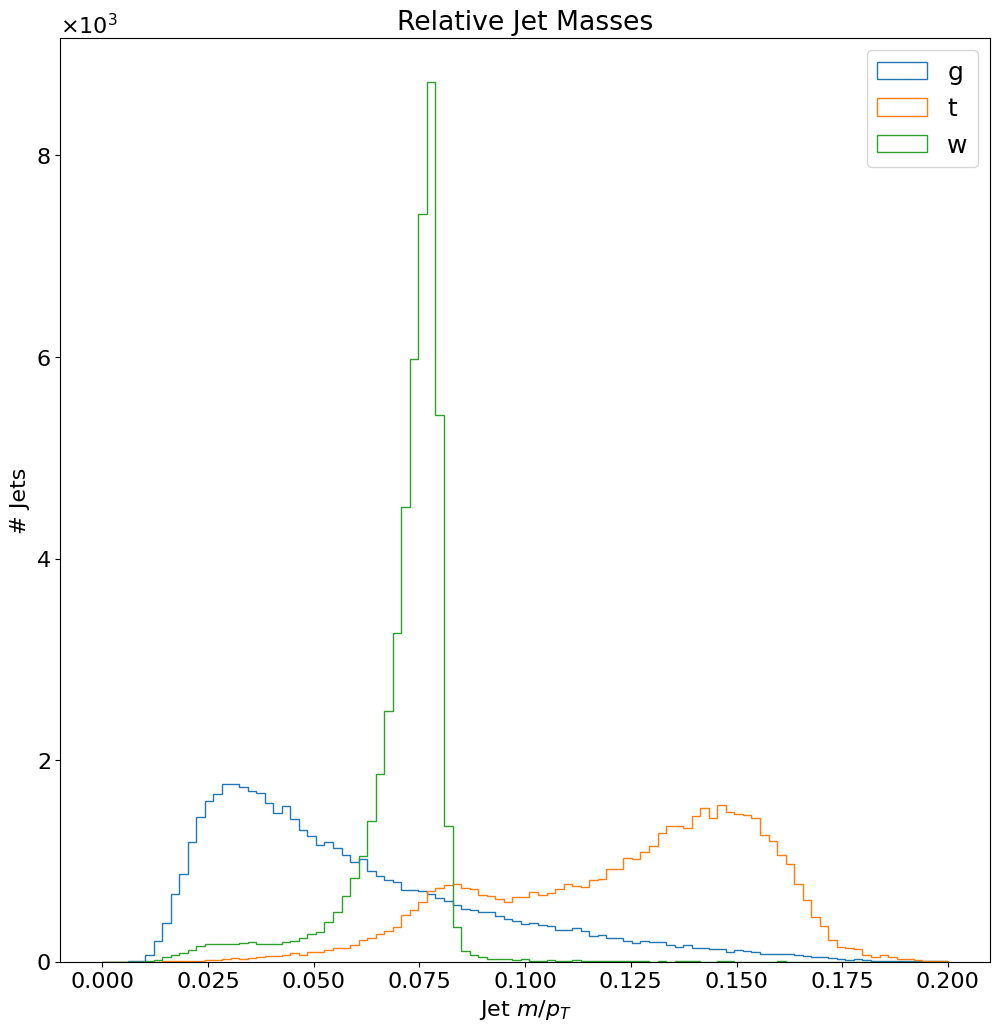

In [10]:
#calculate and plot overall features

import numpy as np
from jetnet.utils import jet_features

fig = plt.figure(figsize=(12, 12))
plt.ticklabel_format(axis="y", scilimits=(0, 0), useMathText=True)

for j in range(num_types):
    jet_type = data_args["jet_type"][j]
    type_selector = jet_data[:, 0] == type_indices[jet_type]  # select jets based on jet_type feat

    jet_masses = jet_features(particle_data[type_selector][:50000])["mass"]
    _ = plt.hist(jet_masses, bins=np.linspace(0, 0.2, 100), histtype="step", label=jet_type)

plt.xlabel("Jet $m/p_{T}$")
plt.ylabel("# Jets")
plt.legend(loc=1, prop={"size": 18})
plt.title("Relative Jet Masses")
plt.show()

In [24]:
"""
Dataset preparation -> go through this to understand the data prep for ParT
"""
import numpy as np
from jetnet.datasets import JetNet
from jetnet.datasets.normalisations import FeaturewiseLinear
from sklearn.preprocessing import OneHotEncoder


# function to one hot encode the jet type and leave the rest of the features as is
#assumes that 0 ([1,0]) is gluon (g) and 1 is top (t) ([0, 1])
def OneHotEncodeType(x: np.ndarray):
    enc = OneHotEncoder(sparse_output=False) #hardcodes that there are only labels 0 and 1
    type_encoded = enc.fit_transform(x[..., 0].reshape(-1, 1))
    other_features = x[..., 1:].reshape(-1, 3)
    return np.concatenate((type_encoded, other_features), axis=-1).reshape(*x.shape[:-1], -1)


data_args = {
    "jet_type": ["g", "t"],  # only selecting gluon and top quark jets
    "data_dir": "datasets/jetnet",
    # these are the default particle features, written here to be explicit
    "particle_features": ["etarel", "phirel", "ptrel", "mask"],
    "num_particles": 10,  # we retain only the 10 highest pT particles for this demo
    "jet_features": ["type", "pt", "eta", "mass"],
    # we don't want to normalise the 'mask' feature so we set that to False
    "particle_normalisation": FeaturewiseLinear(
        normal=True, normalise_features=[True, True, True, False]
    ),
    # pass our function as a transform to be applied to the jet features
    "jet_transform": OneHotEncodeType,
    "download": True,
}

jets_train = JetNet(**data_args, split="train")
jets_valid = JetNet(**data_args, split="valid")


In [25]:
jets_train

Dataset JetNet
    Number of datapoints: 248637
    Data location: datasets/jetnet
    Including ['g', 't'] jets
    Split into train data out of ['train', 'valid', 'test', 'all'] possible splits, with splitting fractions [0.7, 0.15, 0.15]
    Particle features: ['etarel', 'phirel', 'ptrel', 'mask'], max 10 particles per jet
    Jet features: ['type', 'pt', 'eta', 'mass']
    Particle normalisation: Normalising features to zero mean and unit standard deviation, normalising features: [True, True, True, False]
    Jet transform: <function OneHotEncodeType at 0x7fb06b512280>

In [26]:
particle_features, jet_features = jets_train[0]
print(f"Particle features ({data_args['particle_features']}):\n\t{particle_features}")
print(f"\nJet features ({data_args['jet_features']}):\n\t{jet_features}")

Particle features (['etarel', 'phirel', 'ptrel', 'mask']):
	tensor([[ 0.0663,  0.0677,  0.1384,  1.0000],
        [ 0.0594,  0.0806,  0.1115,  1.0000],
        [-0.1404, -0.0924,  0.0937,  1.0000],
        [-0.1381, -0.0970,  0.0838,  1.0000],
        [-0.1406, -0.0895,  0.0747,  1.0000],
        [ 0.0556,  0.0739,  0.0714,  1.0000],
        [ 0.0555,  0.0682,  0.0424,  1.0000],
        [ 0.0629,  0.0853,  0.0423,  1.0000],
        [ 0.0387,  0.0765,  0.0413,  1.0000],
        [ 0.0494,  0.0706,  0.0311,  1.0000]])

Jet features (['type', 'pt', 'eta', 'mass']):
	tensor([ 1.0000e+00,  1.0050e+03, -3.0688e-01,  1.5198e+02])
